<a href="https://www.kaggle.com/code/farukgrrolu/titanic-competation?scriptVersionId=115272832" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Problem Definition

**👋🛳️ Ahoy, welcome to Kaggle! You’re in the right place.
This is the legendary Titanic ML competition – the best, first challenge for you to dive into ML competitions and familiarize yourself with how the Kaggle platform works.**

**The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.**

**Read on or watch the video below to explore more details. Once you’re ready to start competing, click on the "Join Competition button to create an account and gain access to the competition data. Then check out Alexis Cook’s Titanic Tutorial that walks you through step by step how to make your first submission!**

**Challange Details**

**The sinking of the Titanic is one of the most infamous shipwrecks in history.**

**On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.**

**While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.**

**In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).**

# Data Description

**The data has been split into two groups:**

> training set (train.csv)

> test set (test.csv)

**The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.**

**The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.**

**We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.**

**Variable Notes**
> **pclass**: A proxy for socio-economic status (SES)

> **1st** = Upper

> **2nd** = Middle

> **3rd** = Lower

> **age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

> **sibsp**: The dataset defines family relations in this way...

> **Sibling** = brother, sister, stepbrother, stepsister

> **Spouse** = husband, wife (mistresses and fiancés were ignored)

> **parch**: The dataset defines family relations in this way...

> **Parent** = mother, father

> **Child** = daughter, son, stepdaughter, stepson

> **Some children travelled only with a nanny, therefore parch=0 for them.**

# Starting For the Analysis

# 1. Importing Necessary Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler,minmax_scale
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
# to ignore warnings:
import warnings
warnings.filterwarnings('ignore')

# to display all columns:
pd.set_option('display.max_columns', None)

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titaniccsv/titanic.csv
/kaggle/input/titaniccsv/test.csv


#######################
# 2. TRAIN DATASET
#######################

# 2.1 Data Preprocessing

In [3]:
#Function for checking datasets
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [4]:
#uploading the dataset
def load_application_train():
    data = pd.read_csv("/kaggle/input/titaniccsv/titanic.csv", index_col="PassengerId")
    return data

data = load_application_train()
check_df(data)

##################### Shape #####################
(891, 11)
##################### Types #####################
Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object
##################### Head #####################
             Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss

# 2.2 Feature Engineering

**We can drop "Name", "Ticket" as it represents string variables and might not affect result**

In [5]:
print(f'-- Dataset after dropping "Name" and "Ticket"')
data = data.drop(["Name", "Ticket"], axis=1)
data

-- Dataset after dropping "Name" and "Ticket"


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,NaN,S
2,1,1,female,38.0,1,0,71.2833,C85,C
3,1,3,female,26.0,0,0,7.9250,NaN,S
4,1,1,female,35.0,1,0,53.1000,C123,S
5,0,3,male,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,13.0000,NaN,S
888,1,1,female,19.0,0,0,30.0000,B42,S
889,0,3,female,NaN,1,2,23.4500,NaN,S


**Checking missing values**

In [6]:
colnames_with_na = [col for col in data.columns if data[col].isna().any()]
print(f"-- Columns with NA values: \n{', '.join(colnames_with_na)}")
cols_with_na = data[colnames_with_na]
print(f"\n-- NA values count: \n{cols_with_na.isna().sum(axis=0)}")
print(f"\n-- NA values ratio: \n{cols_with_na.isna().sum(axis=0)/cols_with_na.shape[0]}")

-- Columns with NA values: 
Age, Cabin, Embarked

-- NA values count: 
Age         177
Cabin       687
Embarked      2
dtype: int64

-- NA values ratio: 
Age         0.198653
Cabin       0.771044
Embarked    0.002245
dtype: float64


**We can drop "Cabin" features due ratio is 0.77

In [7]:
data = data.drop("Cabin", axis=1 )

In [8]:
#Due embarked have only 2 missing value, it can be filled with most iterable one
print(f'Before arranged:\n{data["Embarked"].value_counts()}')
print(f'After arranged:\n{data.Embarked.fillna("S").value_counts()}')
data["Embarked"] = data.Embarked.fillna("S")

Before arranged:
S    644
C    168
Q     77
Name: Embarked, dtype: int64
After arranged:
S    646
C    168
Q     77
Name: Embarked, dtype: int64


In [9]:
print("-- NA distribution in 'Age' grouped by sex: \n")
data['Age'].isna().groupby(data['Sex']).sum()

-- NA distribution in 'Age' grouped by sex: 



Sex
female     53
male      124
Name: Age, dtype: int64

**Let's fill "Age" based on "Sex"**

In [10]:
data.groupby("Sex").agg({"Age":["median", "mean"]})

Age           
       median       mean
Sex                     
female   27.0  27.915709
male     29.0  30.726645

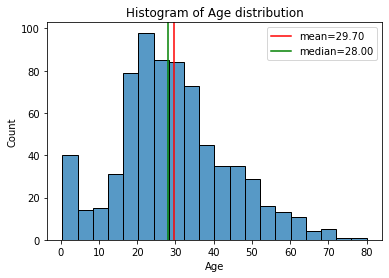

In [11]:
#Let's visualize it
import seaborn as sns
sns.histplot(data['Age'].sort_values().values)
plt.axvline(x=data['Age'].mean(), color='red', label=f'mean={data["Age"].mean():.2f}')
plt.axvline(x=data['Age'].median(), color='green', label=f'median={data["Age"].median():.2f}')
plt.xlabel("Age")
plt.title('Histogram of Age distribution')
plt.legend()
plt.show(block=True)

In [12]:
# we choose median
female_median_age, male_median_age =  data.groupby('Sex')['Age'].agg("median")
print(f"Female median age: {female_median_age}, Male median age: {male_median_age}")

Female median age: 27.0, Male median age: 29.0


In [13]:
data.loc[(data['Age'].isna()) & (data['Sex'] == 'female'), 'Age'] = female_median_age
data.loc[(data['Age'].isna()) & (data['Sex'] == 'male'), 'Age'] = male_median_age
data['Age'].isna().any()

False

In [14]:
#Checking if there are any NA values or not
data.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [15]:
check_df(data)

##################### Shape #####################
(891, 8)
##################### Types #####################
Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object
##################### Head #####################
             Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
PassengerId                                                                
1                   0       3    male  22.0      1      0   7.2500        S
2                   1       1  female  38.0      1      0  71.2833        C
3                   1       3  female  26.0      0      0   7.9250        S
4                   1       1  female  35.0      1      0  53.1000        S
5                   0       3    male  35.0      0      0   8.0500        S
##################### Tail #####################
             Survived  Pclass     Sex   Age  SibSp  Parch   Fare Embarked
PassengerId  

In [16]:
#Checking categorical,numerical features and outlier ones
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.90):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
def check_outlier(dataframe, col_name, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [17]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


In [18]:
cat_cols, num_cols, cat_but_car = grab_col_names(data, cat_th=5, car_th=20)

In [19]:
print(f'Cat_Cols {cat_cols}, Num_Cols {num_cols}, Cat_But_Car {cat_but_car}')

Cat_Cols ['Sex', 'Embarked', 'Survived', 'Pclass'], Num_Cols ['Age', 'SibSp', 'Parch', 'Fare'], Cat_But_Car []


In [20]:
#Implementing label encoder for Sex and Embarked fetures
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
columns = ["Sex", "Embarked"]

for col in columns:
    data[col] = le.fit_transform(data[col])
    print(le.classes_)
      
data.head()

['female' 'male']
['C' 'Q' 'S']


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,2
2,1,1,0,38.0,1,0,71.2833,0
3,1,3,0,26.0,0,0,7.9250,2
4,1,1,0,35.0,1,0,53.1000,2
5,0,3,1,35.0,0,0,8.0500,2


# 2.3. Correlation Analysis

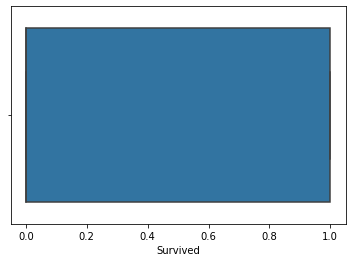

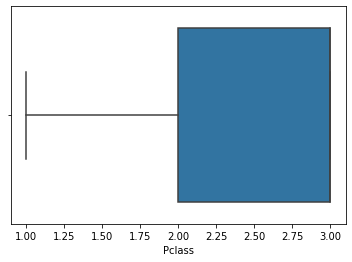

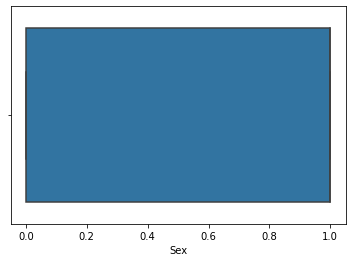

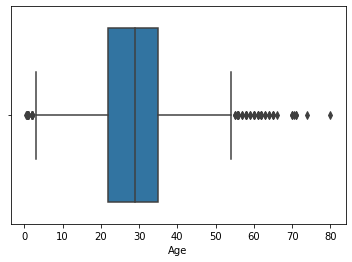

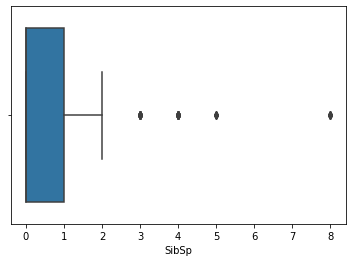

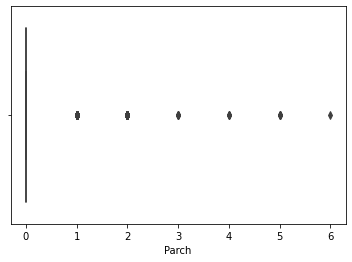

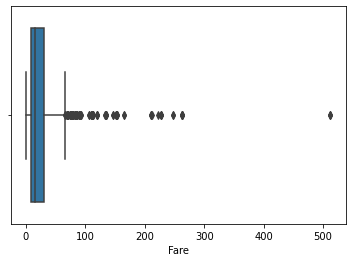

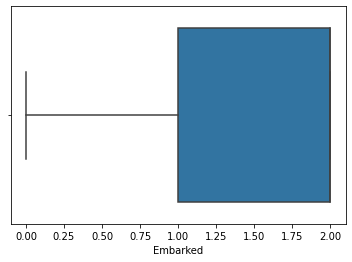

In [21]:
import seaborn as sns

def box_graph(df):
    for column in df.columns:
        sns.boxplot(x=df[column])
        plt.show(block=True)
box_graph(data)

In [22]:
check_outlier(data, "Fare")

True

In [23]:
check_outlier(data, "SibSp")

True

In [24]:
check_outlier(data, "Parch")

True

In [25]:
replace_with_thresholds(data, "Fare")
replace_with_thresholds(data, "SibSp")
replace_with_thresholds(data, "Parch")

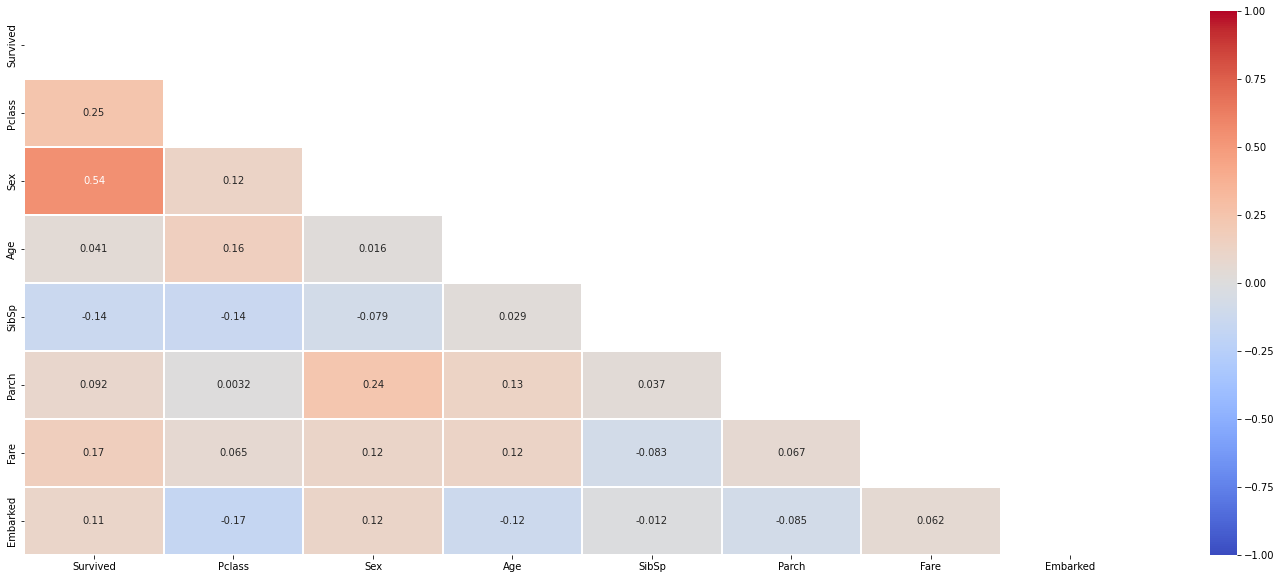

In [26]:
#Correlation with all features
plt.figure(5, figsize=(25, 10))
corr = data.apply(lambda x: pd.factorize(x)[0]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)
plt.show(block=True)

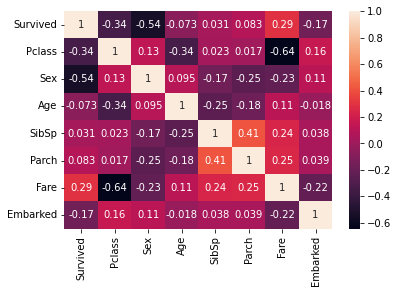

In [27]:
#The otherway for heatmap
sns.heatmap(data.corr(), annot=True)
data.corr()
plt.show()

# 2.4. Data Standard Scaler

In [28]:
# X_scaled = StandardScaler().fit_transform(data[num_cols])
# data[num_cols] = pd.DataFrame(X_scaled, columns=data[num_cols].columns)
# data.head()

scaler = StandardScaler().fit(data[['Fare']])
data[['Fare']] = scaler.transform(data[['Fare']])

#######################
# 3. TEST DATASET
#######################

In [29]:
def load_application_test():
    data = pd.read_csv("/kaggle/input/titaniccsv/test.csv", index_col="PassengerId")
    return data
test = load_application_test()
check_df(test)

##################### Shape #####################
(418, 10)
##################### Types #####################
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object
##################### Head #####################
             Pclass                                          Name     Sex  \
PassengerId                                                                 
892               3                              Kelly, Mr. James    male   
893               3              Wilkes, Mrs. James (Ellen Needs)  female   
894               2                     Myles, Mr. Thomas Francis    male   
895               3                              Wirz, Mr. Albert    male   
896               3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

              Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
PassengerId         

# 3.1. Scaler

In [30]:
X_result = test
Y_result = None

X_result[['Fare']] = scaler.transform(X_result[['Fare']])

# 3.2. Feature Engineering

In [31]:
#We can drop "Name", "Ticket" as it represents string variables and might not affect result
print(f'-- Dataset after dropping "Name" and "Ticket"')
test = test.drop(["Name", "Ticket"], axis=1)
test

-- Dataset after dropping "Name" and "Ticket"


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,
892,3,male,34.5,0,0,-0.597366,NaN,Q
893,3,female,47.0,1,0,-0.619641,NaN,S
894,2,male,62.0,0,0,-0.547445,NaN,Q
895,3,male,27.0,0,0,-0.574981,NaN,S
896,3,female,22.0,1,1,-0.477600,NaN,S
...,...,...,...,...,...,...,...,...
1305,3,male,NaN,0,0,-0.591435,NaN,S
1306,1,female,39.0,0,0,2.117766,C105,C
1307,3,male,38.5,0,0,-0.612925,NaN,S


In [32]:
#Checking missing values
colnames_with_na = [col for col in test.columns if test[col].isna().any()]
print(f"-- Columns with NA values: \n{', '.join(colnames_with_na)}")
cols_with_na = test[colnames_with_na]
print(f"\n-- NA values count: \n{cols_with_na.isna().sum(axis=0)}")
print(f"\n-- NA values ratio: \n{cols_with_na.isna().sum(axis=0)/cols_with_na.shape[0]}")

-- Columns with NA values: 
Age, Fare, Cabin

-- NA values count: 
Age       86
Fare       1
Cabin    327
dtype: int64

-- NA values ratio: 
Age      0.205742
Fare     0.002392
Cabin    0.782297
dtype: float64


In [33]:
#Due Cabin features has 78% of NaN value, we can drop it
test = test.drop("Cabin", axis=1 )

In [34]:
#Due fare have only 1 missing value, it can be filled with mean of the feature
print(f'Before arranged:\n{test["Fare"].value_counts().sum()}')
print(f'After arranged:\n{test.Fare.fillna(test["Fare"].mean()).value_counts().sum()}')
test["Fare"] = test.Fare.fillna(test["Fare"].mean())

Before arranged:
417
After arranged:
418


In [35]:
print("-- NA distribution in 'Age' grouped by sex: \n")
test['Age'].isna().groupby(test['Sex']).sum()

-- NA distribution in 'Age' grouped by sex: 



Sex
female    25
male      61
Name: Age, dtype: int64

In [36]:
#Let's fill "Age" based on sex
test.groupby("Sex").agg({"Age":["median", "mean"]})

Age           
       median       mean
Sex                     
female   27.0  30.272362
male     27.0  30.272732

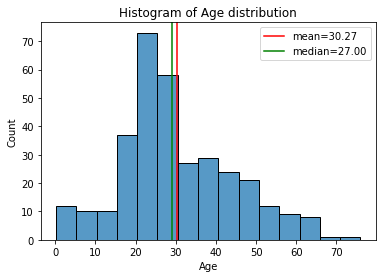

In [37]:
#Let's visualize it
sns.histplot(test['Age'].sort_values().values)
plt.axvline(x=test['Age'].mean(), color='red', label=f'mean={test["Age"].mean():.2f}')
plt.axvline(x=data['Age'].median(), color='green', label=f'median={test["Age"].median():.2f}')
plt.xlabel("Age")
plt.title('Histogram of Age distribution')
plt.legend()
plt.show(block=True)

In [38]:
# we choose median
female_median_age, male_median_age =  test.groupby('Sex')['Age'].agg("median")
print(f"Female median age: {female_median_age}, Male median age: {male_median_age}")

Female median age: 27.0, Male median age: 27.0


In [39]:
test.loc[(test['Age'].isna()) & (test['Sex'] == 'female'), 'Age'] = female_median_age
test.loc[(test['Age'].isna()) & (test['Sex'] == 'male'), 'Age'] = male_median_age
test['Age'].isna().any()

False

In [40]:
#Checking if there are any NA values or not
test.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [41]:
cat_cols, num_cols, cat_but_car = grab_col_names(test, cat_th=5, car_th=20)

In [42]:
print(f'Cat_Cols {cat_cols}, Num_Cols {num_cols}, Cat_But_Car {cat_but_car}')

Cat_Cols ['Sex', 'Embarked', 'Pclass'], Num_Cols ['Age', 'SibSp', 'Parch', 'Fare'], Cat_But_Car []


In [43]:
#Implementing lable encoder for Sex and Embarked fetures
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
columns = ["Sex", "Embarked"]

In [44]:
for col in columns:
    test[col] = le.fit_transform(test[col])
    print(le.classes_)

['female' 'male']
['C' 'Q' 'S']


In [45]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
892,3,1,34.5,0,0,-0.597366,1
893,3,0,47.0,1,0,-0.619641,2
894,2,1,62.0,0,0,-0.547445,1
895,3,1,27.0,0,0,-0.574981,2
896,3,0,22.0,1,1,-0.477600,2


# 3.3. Correlation analysis

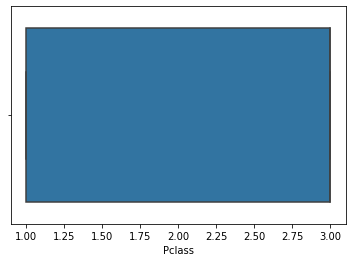

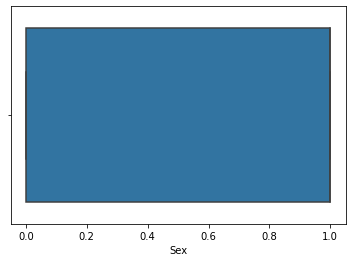

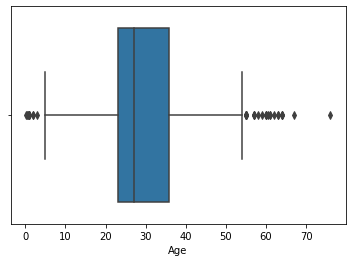

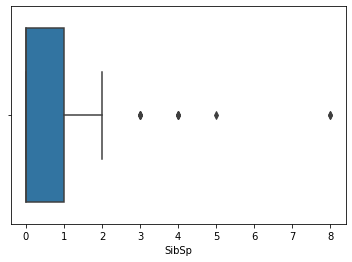

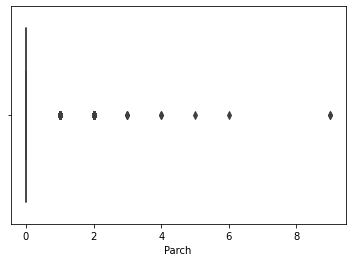

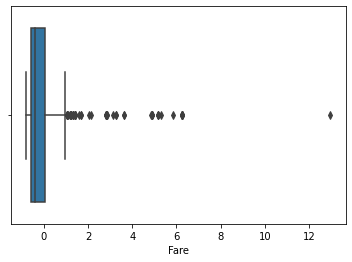

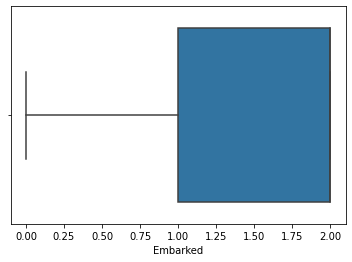

In [46]:
import seaborn as sns

def box_graph(df):
     for column in df.columns:
         sns.boxplot(x=df[column])
         plt.show(block=True)
box_graph(test)

In [47]:
check_outlier(test, "Fare")
check_outlier(test, "SibSp")
check_outlier(test, "Parch")

True

In [48]:
replace_with_thresholds(test, "Fare")
replace_with_thresholds(test, "SibSp")
replace_with_thresholds(test, "Parch")

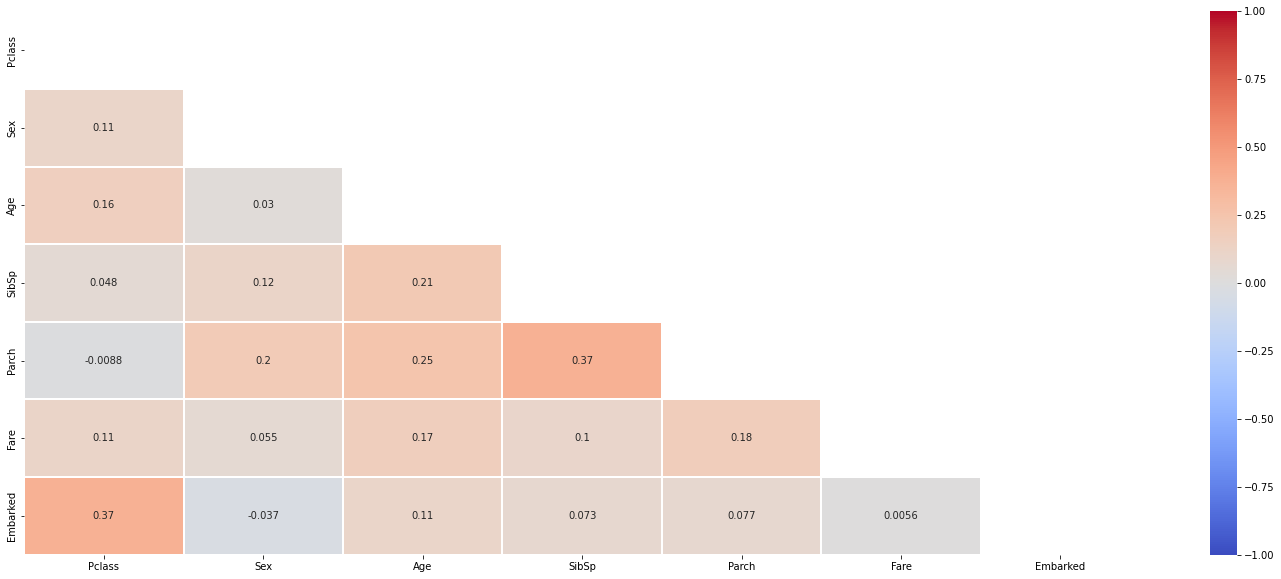

In [49]:
#Correlation with all features
plt.figure(5, figsize=(25, 10))
corr = test.apply(lambda x: pd.factorize(x)[0]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)
plt.show(block=True)

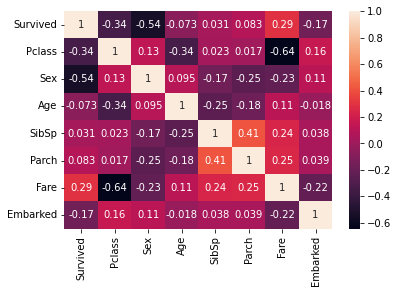

In [50]:
#The otherway for heatmap
sns.heatmap(data.corr(), annot=True)
test.corr()
plt.show()

# 4. MODEL

In [51]:
y = data["Survived"]
X = data.drop("Survived", axis=1)

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

**We'll use "Randon Forest" algorith after comparing with "Desicion Tree", "SVC" models. The best params are determined via GridSearch function**

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(max_depth=25, min_samples_leaf=4, min_samples_split=9, n_estimators=30)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

print(f"Train accuracy: {clf.score(X_train, y_train) * 100:.3f}%")
print(f"Test accuracy: {clf.score(X_test, y_test) * 100:.3f}%")
print(f"CrossVal score: {cross_val_score(clf, X, y, cv=10).mean() * 100:.3f}%")

Train accuracy: 87.480%
Test accuracy: 79.851%
CrossVal score: 82.497%


In [54]:
#Submission
submit_df = test.drop(test.columns, axis=1)
submit_df['Survived'] = clf.predict(test)
submit_df.to_csv('submission.csv')
print("Your submission was successfully saved!")

Your submission was successfully saved!
